# Quantum Phase Estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import Aer, transpile, assemble
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

/home/ciel/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


## Example 1: Finding the phase of the T-gate
Recalling the definition of the T-gate, it adds a phase of $e^{\frac{i\pi}{4}}$ to the state $|1\rangle$. The quantum phase estimation algorithm finds the eigenvalue of a unitary matrix as $e^{2i\pi\theta}$. Here we expect to find $\theta=\frac{1}{8}$. Note that we can find the value without any error.

### Initializing the 2 registers
The first 3 qubits would act as counting qubits, while the last qubit as the eigenstate of the unitary operator.

In [2]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c: 3/═════

### Applying the Hadamard gate on the first register

In [3]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘
c: 3/═════

### Applying the controlled unitary operations

In [4]:
angle = 2*math.pi/8
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3)
    repetitions *= 2
qpe.draw()

┌───┐                                                               
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────
     ├───┤ │                                                             
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────
     ├───┤ │        │        │                                           
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4) 
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■───────
     └───┘                                                               
c: 3/════════════════════════════════════════════════════════════════════

### Applying the inverse quantum Fourier transform

In [5]:
def qft_dagger(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

qpe.barrier()
qft_dagger(qpe, 3)
qpe.barrier()
qpe.draw()

┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──X─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░    »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░────»
     └───┘                                                                ░    »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                                         ░ 
«q_0: ┤ H ├─■──────────────■────────────────────────░─
«     └───┘ │P(-π/2) ┌───┐ │                        ░ 
«q_1: ──────■────────┤ H ├─┼─────────■──────────────░─
«                    └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░ 
«q_2: ─────────────────────■─────────■────────┤ H ├─░─
«                                             └───┘ ░ 
«q_3: ──────────────────────────────────────────────░─
«                                                   ░ 
«c: 3/════════════════════════════════════════════════
«

### Measuring the first register on the computational basis 

In [6]:
for n in range(3):
    qpe.measure(n, n)
qpe.draw()

┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──X─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░    »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░────»
     └───┘                                                                ░    »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                                         ░ ┌─┐      
«q_0: ┤ H ├─■──────────────■────────────────────────░─┤M├──────
«     └───┘ │P(-π/2) ┌───┐ │                        ░ └╥┘┌─┐   
«q_1: ──────■────────┤ H ├─┼─────────■──────────────░──╫─┤M├───
«                    └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ─────────────────────■─────────■────────┤ H ├─░──╫──╫─┤M├
«                                             └───┘ ░  ║  ║ └╥┘
«q_3: ──────────────────────────────────────────────░──╫──╫──╫─
«                                                   ░  ║  ║  ║ 
«c: 3/═════════════════════════════════════════════════╩══╩══╩═
«                                                      0  1  2

### Getting the result  

/home/ciel/.local/lib/python3.6/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


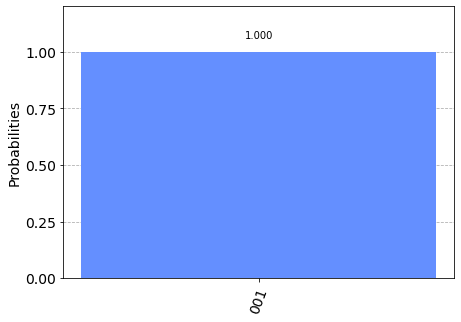

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()

plot_histogram(counts)

Here we got the result 001 with certainty, which is 1 in decimal. Then we can divide the result by $2^n=2^3=8$ to get $\theta$, namely $\frac{1}{8}$, which is exactly what we are expecting!

## Example 2: Estimating a phase $\theta$ such that $2^n\theta$ is not an integer
We have seen that when $2^n\theta$ is an integer, we can obtain the phase by measuring the qubits of the first register without any error. But what about the case where $2^n\theta$ is not an integer? 

For the following example, let's consider $\theta=\frac{1}{3}$. First set up the circuit like what we have done in the lsat section.

In [8]:
qpe2 = QuantumCircuit(4, 3)

for qubit in range(3):
    qpe2.h(qubit)
qpe2.x(3)

angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

qft_dagger(qpe2, 3)

for n in range(3):
    qpe2.measure(n, n)

qpe2.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_3: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«                  ┌───┐                                   ┌─┐           
«q_0: ───────────X─┤ H ├─■──────────────■──────────────────┤M├───────────
«                │ └───┘ │P(-π/2) ┌───┐ │                  └╥┘     ┌─┐   
«q_1: ───────────┼───────■────────┤ H ├─┼─────────■─────────╫──────┤M├───
«                │                └───┘ │P(-π/4)  │P(-π/2)  ║ ┌───┐└╥┘┌─┐
«q_2: ─■─────────X──────────────────────■─────────■─────────╫─┤ H ├─╫─┤M├
«      │P(2π/3)                                             ║ └───┘ ║ └╥┘
«q_3: ─■────────────────────────────────────────────────────╫───────╫──╫─
«                                                           ║       ║  ║ 
«c: 3/══════════════════════════════════════════════════════╩═══════╩══╩═
«                                                           0       1  2

Then conduct measurment:

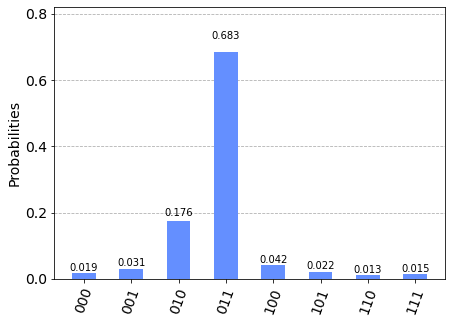

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe2 = transpile(qpe2, aer_sim)
qobj = assemble(t_qpe2, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()

plot_histogram(counts)

Since we are expecting the result $\theta=0.3333\dots$, which lies between $\frac{[010]_2}{8}=\frac{2}{8}$ and $\frac{[011]_2}{8}=\frac{3}{8}$. It's a good thing to know that we are very likely to get these two results from the measurement. However, even if we did get these two results, the true value still differs from them quite a lot, i.e., $\theta=0.25$ (off by 25%) and $\theta=0.375$ (off by 13%). 

### Example 3: Getting more precision
To (not completely tho) solve this problem, we can simply use more counting qubits in the first register. Here we will be usinng 5 instead of 3 qubits.

In [10]:
qpe3 = QuantumCircuit(6, 5)

for qubit in range(5):
    qpe3.h(qubit)
qpe3.x(5)

angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

qft_dagger(qpe3, 5)

for n in range(5):
    qpe3.measure(n, n)

qpe3.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │         │         │         │         │         │        »
q_4: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_5: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │         │         │         │         │         │         │        »
«q_4: ─┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ────────────────────────X─────────────────────────────────────────────»
«                             │                                             »
«q_2: ────────────────────────┼─────────────────────────────────────────────»
«                             │                                             »
«q_3: ─■─────────■────────────X─────────────────────────────────────────────»
«      │         │                                                          »
«q_4: ─┼─────────┼─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ─────────────────────────────────

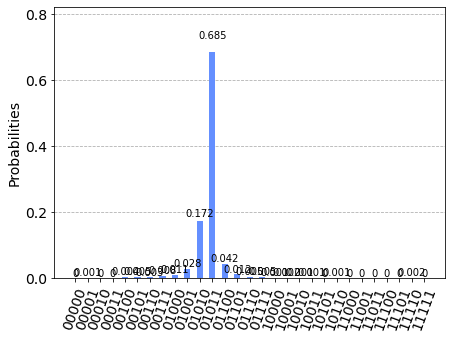

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe3 = transpile(qpe3, aer_sim)
qobj = assemble(t_qpe3, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()

plot_histogram(counts)

The two most likely results are now $[01010]_2=10$ and $[01011]_2=11$, corresponding to $\theta=\frac{10}{2^5}=0.313$ and $\frac{10}{2^5}=0.344$. These two results differ from the true value $\frac{1}{3}$ by 6% and 3% respectively. We can see that the precision has improved considerably. 